##import

In [0]:
import numpy as np
import scipy.io
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os

##Download

In [1]:
!wget https://physionet.org/files/challenge-2017/1.0.0/training2017.zip?download
!wget https://physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af?download
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-noisy
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-normal
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-other

--2020-03-06 16:52:11--  https://physionet.org/files/challenge-2017/1.0.0/training2017.zip?download
Resolving physionet.org (physionet.org)... 18.13.52.205
Connecting to physionet.org (physionet.org)|18.13.52.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99226822 (95M) [application/zip]
Saving to: ‘training2017.zip?download’

training2017.zip?do 100%[===================>]  94.63M  72.0MB/s    in 1.3s    

2020-03-06 16:52:12 (72.0 MB/s) - ‘training2017.zip?download’ saved [99226822/99226822]



In [2]:
!unzip /content/training2017.zip?download

Streaming output truncated to the last 5000 lines.
  inflating: training2017/A06031.hea  
  inflating: training2017/A06031.mat  
  inflating: training2017/A06032.hea  
  inflating: training2017/A06032.mat  
  inflating: training2017/A06033.hea  
  inflating: training2017/A06033.mat  
  inflating: training2017/A06034.hea  
  inflating: training2017/A06034.mat  
  inflating: training2017/A06035.hea  
  inflating: training2017/A06035.mat  
  inflating: training2017/A06036.hea  
  inflating: training2017/A06036.mat  
  inflating: training2017/A06037.hea  
  inflating: training2017/A06037.mat  
  inflating: training2017/A06038.hea  
  inflating: training2017/A06038.mat  
  inflating: training2017/A06039.hea  
  inflating: training2017/A06039.mat  
  inflating: training2017/A06040.hea  
  inflating: training2017/A06040.mat  
  inflating: training2017/A06041.hea  
  inflating: training2017/A06041.mat  
  inflating: training2017/A06042.hea  
  inflating: training2017/A06042.mat  
  inflating: 

##Data_preperation

In [0]:
f = open("/content/RECORDS-af?download", "r")
Records_af = f.read().split("\n")#spilt by '/' and choose the 2nd word to get the name
f = open("/content/RECORDS-noisy", "r")
Records_noisy = f.read().split("\n")
f = open("/content/RECORDS-normal", "r")
Records_noisy = f.read().split("\n")
f = open("/content/RECORDS-other", "r")
Records_noisy = f.read().split("\n")

normal

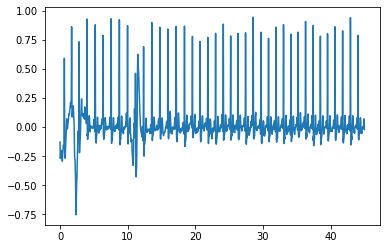

In [53]:
mat = scipy.io.loadmat('/content/training2017/A00001.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(train_data)/200,num = len(train_data)),train_data/1000)

af_rythm

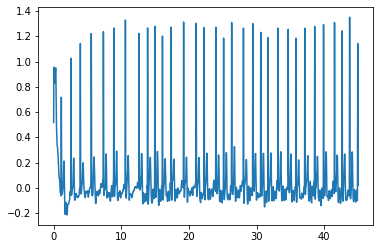

In [56]:
mat = scipy.io.loadmat('/content/training2017/A00004.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(train_data)/200,num = len(train_data)),train_data/1000)

other

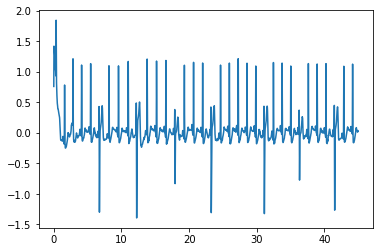

In [59]:
mat = scipy.io.loadmat('/content/training2017/A00077.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(train_data)/200,num = len(train_data)),train_data/1000)

noise

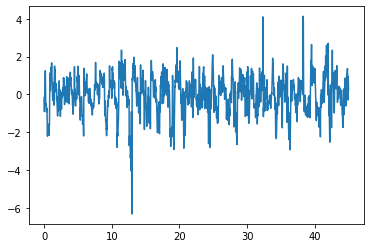

In [61]:
mat = scipy.io.loadmat('/content/training2017/A01246.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(train_data)/200,num = len(train_data)),train_data/1000)

train_set

In [0]:
dir = "/content/training2017"
train_dataset = []
file_order = []
for i in range(0,8528):
  train_dataset.append([])
i = 0
for file in os.listdir( dir ):
  if file.endswith( ".mat" ):
    mat = scipy.io.loadmat('/content/training2017/'+file)
    file_order.append(file)
    train_data = np.array(mat['val']).squeeze()
    for j in train_data:
      train_dataset[i].append(j)
    i+=1

In [152]:
print(file_order)

['A04133.mat', 'A01186.mat', 'A02352.mat', 'A08498.mat', 'A02972.mat', 'A00224.mat', 'A08365.mat', 'A01445.mat', 'A04389.mat', 'A07865.mat', 'A03100.mat', 'A01794.mat', 'A01336.mat', 'A05718.mat', 'A01958.mat', 'A03929.mat', 'A01869.mat', 'A07056.mat', 'A05954.mat', 'A07954.mat', 'A04853.mat', 'A01897.mat', 'A00710.mat', 'A05384.mat', 'A02701.mat', 'A01601.mat', 'A03688.mat', 'A02319.mat', 'A05142.mat', 'A05547.mat', 'A04075.mat', 'A01199.mat', 'A01379.mat', 'A08071.mat', 'A08358.mat', 'A02767.mat', 'A07589.mat', 'A02138.mat', 'A05370.mat', 'A00102.mat', 'A02916.mat', 'A05023.mat', 'A06618.mat', 'A00047.mat', 'A05073.mat', 'A06419.mat', 'A00523.mat', 'A01098.mat', 'A00252.mat', 'A02368.mat', 'A03601.mat', 'A07074.mat', 'A03921.mat', 'A03278.mat', 'A07166.mat', 'A07252.mat', 'A05309.mat', 'A01483.mat', 'A00593.mat', 'A05019.mat', 'A06828.mat', 'A01988.mat', 'A06736.mat', 'A05848.mat', 'A04551.mat', 'A01433.mat', 'A03312.mat', 'A03163.mat', 'A01844.mat', 'A05860.mat', 'A01215.mat', 'A075